In [96]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Creating helper function

In [71]:
db = "chinook.db"

#create run_query() function, that takes SQL query as an argument and returns pandas dataframe of that query.
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

#create run_command() function that takes a SQL command as an argument and executes it using the sqlite module.
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

#create show_tables() function that calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    q = '''
        SELECT
            name, 
            type 
        FROM sqlite_master 
        WHERE type IN ("table", "view");
        '''
    return run_query(q)

First, let's check all the talbes in "chinook.db"

In [70]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting new albums to purchase

The Chinook record store has just signed a deal with a new record label, and we are tasked with selecting the first three albums that will be added to the store, from a list of four.

In [79]:
import prettytable as pt
tb1 = pt.PrettyTable()
tb1.field_names = ['ArtistName', 'Genre']
tb1.add_row(['Regal', 'Hip-HOP'])
tb1.add_row(['Red Tone', 'Punk'])
tb1.add_row(['Meteor and the Girls', 'Pop'])
tb1.add_row(['Slim Jim Bites', 'Blues'])
tb1.align = 'l'
print(tb1)

+----------------------+---------+
| ArtistName           | Genre   |
+----------------------+---------+
| Regal                | Hip-HOP |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |
+----------------------+---------+


To find out which album to purchase, we want to search for genre that sell most tracks in the USA.

In [66]:
tracks_sold_in_USA = '''
SELECT 
    il.invoice_line_id,
    il.invoice_id,
    il.track_id,
    i.customer_id,
    i.billing_country
FROM invoice_line il
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
'''

run_query(tracks_sold_in_USA)

,invoice_line_id,invoice_id,track_id,customer_id,billing_country
0,1,1,1158,18,USA
1,2,1,1159,18,USA
2,3,1,1160,18,USA
3,4,1,1161,18,USA
4,5,1,1162,18,USA
5,6,1,1163,18,USA
6,7,1,1164,18,USA
7,8,1,1165,18,USA
8,9,1,1166,18,USA
9,10,1,1167,18,USA


In [100]:
album_to_purchase = '''
WITH tracks_sold_in_USA AS (
SELECT 
    il.invoice_line_id,
    il.invoice_id,
    il.track_id,
    i.customer_id,
    i.billing_country
FROM invoice_line il
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
)

SELECT
    genre.name genre,
    COUNT(track.track_id) tracks_sold,
    CAST(COUNT(track.track_id) AS FLOAT) / (SELECT COUNT(*) FROM tracks_sold_in_USA) percentage_sold 
FROM tracks_sold_in_USA tusa
INNER JOIN track ON track.track_id = tusa.track_id
INNER JOIN genre on genre.genre_id = track.genre_id
GROUP BY genre.genre_id
ORDER BY tracks_sold DESC
LIMIT 10;
'''
run_query(album_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


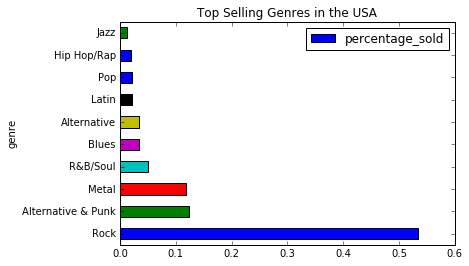

In [101]:
df = run_query(album_to_purchase)
df.plot.barh(x='genre', y='percentage_sold',
             title='Top Selling Genres in the USA')

Based on the top-10 sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

1. Red Tone (Punk)
2. Slim Jim Bites (Blues)
3. Meteor and the Girls (Pop)

## Analyzing Employee Sales Performance

Next, we want to analyze the purchases of customers belonging to each employee and see if any sales support agent is performing either better or worse than the others.

In [140]:
customer_rep_sales = '''
SELECT 
    c.customer_id,
    SUM(i.total) total,
    c.support_rep_id
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY c.customer_id
'''

run_query(customer_rep_sales)

,customer_id,total,support_rep_id
0,1,108.90,3
1,2,82.17,5
2,3,99.99,3
3,4,72.27,4
4,5,144.54,4
5,6,128.70,5
6,7,69.30,5
7,8,60.39,4
8,9,37.62,4
9,10,60.39,4


In [147]:
employee_sales_performance = '''
WITH customer_rep_sales AS (
SELECT 
    c.customer_id,
    SUM(i.total) total,
    c.support_rep_id
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY c.customer_id
)

SELECT 
    e.employee_id,
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date,
    SUM(crs.total) total_sales,
    SUM(crs.total) / (SELECT SUM(total) FROM customer_rep_sales) percentage_sold 
FROM customer_rep_sales crs
INNER JOIN employee e ON e.employee_id = crs.support_rep_id
GROUP BY e.employee_id
'''

run_query(employee_sales_performance)

,employee_id,employee_name,hire_date,total_sales,percentage_sold
0,3,Jane Peacock,2017-04-01 00:00:00,1731.51,0.367669
1,4,Margaret Park,2017-05-03 00:00:00,1584.00,0.336346
2,5,Steve Johnson,2017-10-17 00:00:00,1393.92,0.295985


From the result, Jane has the most sales and Steve has the lowest. 
It seems like the difference in sales approximately corresponds to the differences in their hiring dates.

## Analyzing Sales by Country

Next, we decide to analyze purchases data based on different countries.

When a country has only one customer, we catagorize them as "Other" group.

In [255]:
sales_by_country = '''
SELECT
   billing_country,
   COUNT(DISTINCT customer_id) num_of_customer,
   COUNT(invoice_id) num_of_order,
   SUM(total) total
FROM invoice 
GROUP BY billing_country
'''

run_query(sales_by_country)

,billing_country,num_of_customer,num_of_order,total
0,Argentina,1,5,39.60
1,Australia,1,10,81.18
2,Austria,1,9,69.30
3,Belgium,1,7,60.39
4,Brazil,5,61,427.68
5,Canada,8,76,535.59
6,Chile,1,13,97.02
7,Czech Republic,2,30,273.24
8,Denmark,1,10,37.62
9,Finland,1,11,79.20


In [258]:
sorted_sales_by_country = '''
WITH sales_by_country AS (
SELECT
   billing_country,
   COUNT(DISTINCT customer_id) num_of_customer,
   COUNT(invoice_id) num_of_order,
   SUM(total) total
FROM invoice 
GROUP BY billing_country
)

SELECT
    CASE
        WHEN num_of_customer = 1 THEN 'Other'
        ELSE billing_country
    END AS country,
    SUM(num_of_customer) num_of_customer,
    SUM(total) total_sales,
    SUM(total) / SUM(num_of_customer) average_sales_per_customer,
    SUM(total) / SUM(num_of_order) average_order_value
FROM sales_by_country
GROUP BY num_of_customer
ORDER BY total DESC
'''

run_query(sorted_sales_by_country)

,country,num_of_customer,total_sales,average_sales_per_customer,average_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,France,10,816.75,81.675000,7.358108
3,Germany,4,334.62,83.655000,8.161463
4,United Kingdom,3,245.52,81.840000,8.768571
5,Portugal,6,641.52,106.920000,8.019000
6,Other,15,1094.94,72.996000,7.448571


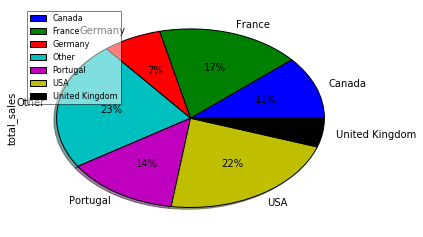

In [280]:
df2 = run_query(sorted_sales_by_country)

df2.groupby(['country']).sum().plot(
    kind='pie', y='total_sales', autopct='%1.0f%%', shadow=True)
plt.legend(loc=2, prop={'size': 8}, framealpha=0.5)

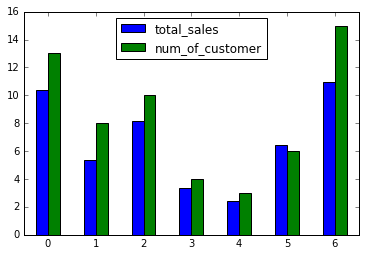

In [301]:
df2 = run_query(sorted_sales_by_country)
df2['total_sales'] = df2['total_sales'] / 100
df2 = df2[['total_sales', 'num_of_customer']]

df2.plot.bar(rot=0)

From the result, customers from USA create most sales, while customers from United Kingdom aveage largest sales per order.

## Purchase Policy: Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

1. purchase a whole album
2. purchase a collection of one or more individual tracks.

When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.